# 🧪 PyTorch Lab 2: Newton Method for logistic regression


You already know **gradient descent**: update the parameters in the opposite direction of the gradient, with a fixed or adaptive step size.

**Newton’s method** goes a step further. Instead of using only the first derivative (the gradient), it also uses the **second derivative information** (the Hessian matrix). Around the current point, we approximate the loss by a quadratic function, then jump directly to its minimum.  

The update rule is:

$$
w_{k+1} = w_k - H^{-1}(w_k)\,\nabla f(w_k)
$$

where:  
- $ \nabla f(w_k)$ is the gradient at the current point,  
- $H(w_k)$ is the Hessian (matrix of second derivatives).  


We'll train on a small **real dataset** (Breast Cancer Wisconsin from scikit-learn). If scikit-learn isn't available, we fall back to a tiny embedded Iris-binary subset.

## 0. Setup

In [1]:
import torch
torch.set_default_dtype(torch.float64)
print('PyTorch version:', torch.__version__)
torch.manual_seed(0)

PyTorch version: 2.8.0+cpu


## 1. Load a real dataset and prepare tensors

In [2]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import torch

# Load iris dataset
data = load_iris()
X = data['data']
y = data['target']

# Convert to binary classification: "setosa (0)" vs "not setosa (1)"
y = (y != 0).astype(float)

# Standardize features
X = StandardScaler().fit_transform(X)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.get_default_dtype())
y = torch.tensor(y, dtype=torch.get_default_dtype())

n, d = X.shape

# Add bias column
X = torch.cat([torch.ones(n, 1, dtype=X.dtype), X], dim=1)
d = d + 1
print(f"Tensors: X={tuple(X.shape)}, y={tuple(y.shape)}, d={d}")


Tensors: X=(150, 5), y=(150,), d=5


## 2. Define logistic loss (autograd will handle grad & Hessian)

In [3]:
import torch

def logistic_loss(w, X, y):
    z = X @ w
    p = torch.sigmoid(z)
    eps = 1e-12
    nll = - (y * torch.log(p + eps) + (1 - y) * torch.log(1 - p + eps)).mean()
    return nll

# Use double for more stable second derivatives (optional)
w = torch.nn.Parameter(torch.rand(X.shape[1], dtype=torch.float64), requires_grad=True)

# ----- compute loss -----
loss = logistic_loss(w, X, y)
print("loss:", loss.item())

grad = torch.autograd.functional.jacobian(lambda w_: logistic_loss(w_, X, y), w)
print(grad)

H = torch.autograd.functional.hessian(lambda w_: logistic_loss(w_, X, y), w)
print(H)


loss: 0.23878280685050943
tensor([-0.0409, -0.0449,  0.2074, -0.1258, -0.1135])
tensor([[ 0.1280, -0.0445,  0.0006, -0.0419, -0.0438],
        [-0.0445,  0.0781, -0.0279,  0.0739,  0.0694],
        [ 0.0006, -0.0279,  0.1841, -0.0908, -0.0800],
        [-0.0419,  0.0739, -0.0908,  0.1093,  0.1034],
        [-0.0438,  0.0694, -0.0800,  0.1034,  0.1037]])


## 4. Train with Newton–Raphson (autograd)

Gradient descent stopped at epoch 94
Newton's method stopped at epoch 4


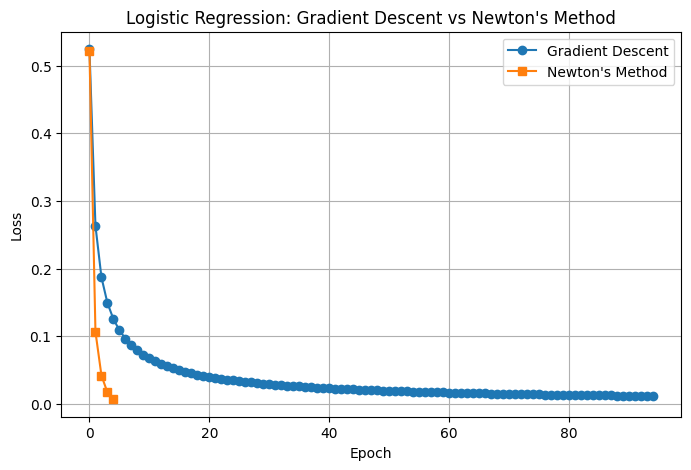

In [59]:
import matplotlib.pyplot as plt


# Parameters
n_epoch = 100
eps = 0.01
alpha =  1# learning rate (might need tuning)
loss_grad = []
loss_newton = []

# ----- Gradient descent -----
w = torch.nn.Parameter(torch.rand(X.shape[1], dtype=torch.float64), requires_grad=True)
for epoch in range(n_epoch):
    loss = logistic_loss(w, X, y)
    loss_grad.append(loss.item())

    grad = torch.autograd.functional.jacobian(lambda w_: logistic_loss(w_, X, y), w)

    w = w - alpha * grad  # gradient descent step

    if torch.norm(grad) < eps:
        break
print(f"Gradient descent stopped at epoch {epoch}")

# ----- Newton's method -----
w = torch.nn.Parameter(torch.rand(X.shape[1], dtype=torch.float64), requires_grad=True)
for epoch in range(n_epoch):
    loss = logistic_loss(w, X, y)
    loss_newton.append(loss.item())

    grad = torch.autograd.functional.jacobian(lambda w_: logistic_loss(w_, X, y), w)
    H = torch.autograd.functional.hessian(lambda w_: logistic_loss(w_, X, y), w)

    w = w - torch.linalg.solve(H, grad)  # Newton step (solve is safer than inv)

    if torch.norm(grad) < eps:
        break
print(f"Newton's method stopped at epoch {epoch}")

# ----- Plot both loss curves -----
plt.figure(figsize=(8,5))
plt.plot(loss_grad, label="Gradient Descent", marker="o")
plt.plot(loss_newton, label="Newton's Method", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Logistic Regression: Gradient Descent vs Newton's Method")
plt.legend()
plt.grid(True)
plt.show()
